# Comparativas entre entrenamientos

Comenzamos definiendo las variables comunes a todos los entrenamientos. 
Más abajo se definen también **train_gen** y **val_gen** como generadores de imágenes de los conjuntos de entrenamiento y de validación.

Además, notamos que las imágenes utilizadas para las comparativas están los vectores **img_train** e **img_val** de **batch_size** imágenes. De la misma forma con **mask_train** y **mask_val** para las máscaras resultado originales.

¡Utilizamos attention! **c'=64**

**CON** augmentations durante el entrenamiento

In [1]:
OUTPUT_CHANNELS=91
input_shape=(640,640)
categories=['nothing','person','bicycle','car','motorcycle','airplane','bus','train','truck','boat',
            'traffic light','fire hydrant','street sign','stop sign','parking meter','bench','bird',
            'cat','dog','horse','sheep', 'cow','elephant','bear','zebra','giraffe','hat','backpack',
            'umbrella','shoe','eye glasses','handbag','tie','suitcase','frisbee','skis','snowboard',
            'sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket',
            'bottle','plate','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich',
            'orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant',
            'bed','mirror','dining table','window','desk','toilet','door','tv','laptop','mouse','remote',
            'keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','blender','book',
            'clock','vase','scissors','teddy bear','hair drier','tooth brush', 'hair brush']
path_train = '../../../COCO2017'
batch_size = 4 # En el entrenamiento se ha utilizado 16 
               #pero pondremos como valor 4 para generar cuatro imagenes cada vez en los generadores de imágenes
epochs=100

### Importamos paquetes necesarios:

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from classification_models.tfkeras import Classifiers
import json

### Creamos el modelo y definimos otras funciones útiles

La función *gen_data* esta definida con augmentations pero debe de notarse que en la segunda ejecución estas sí son utilizadas.

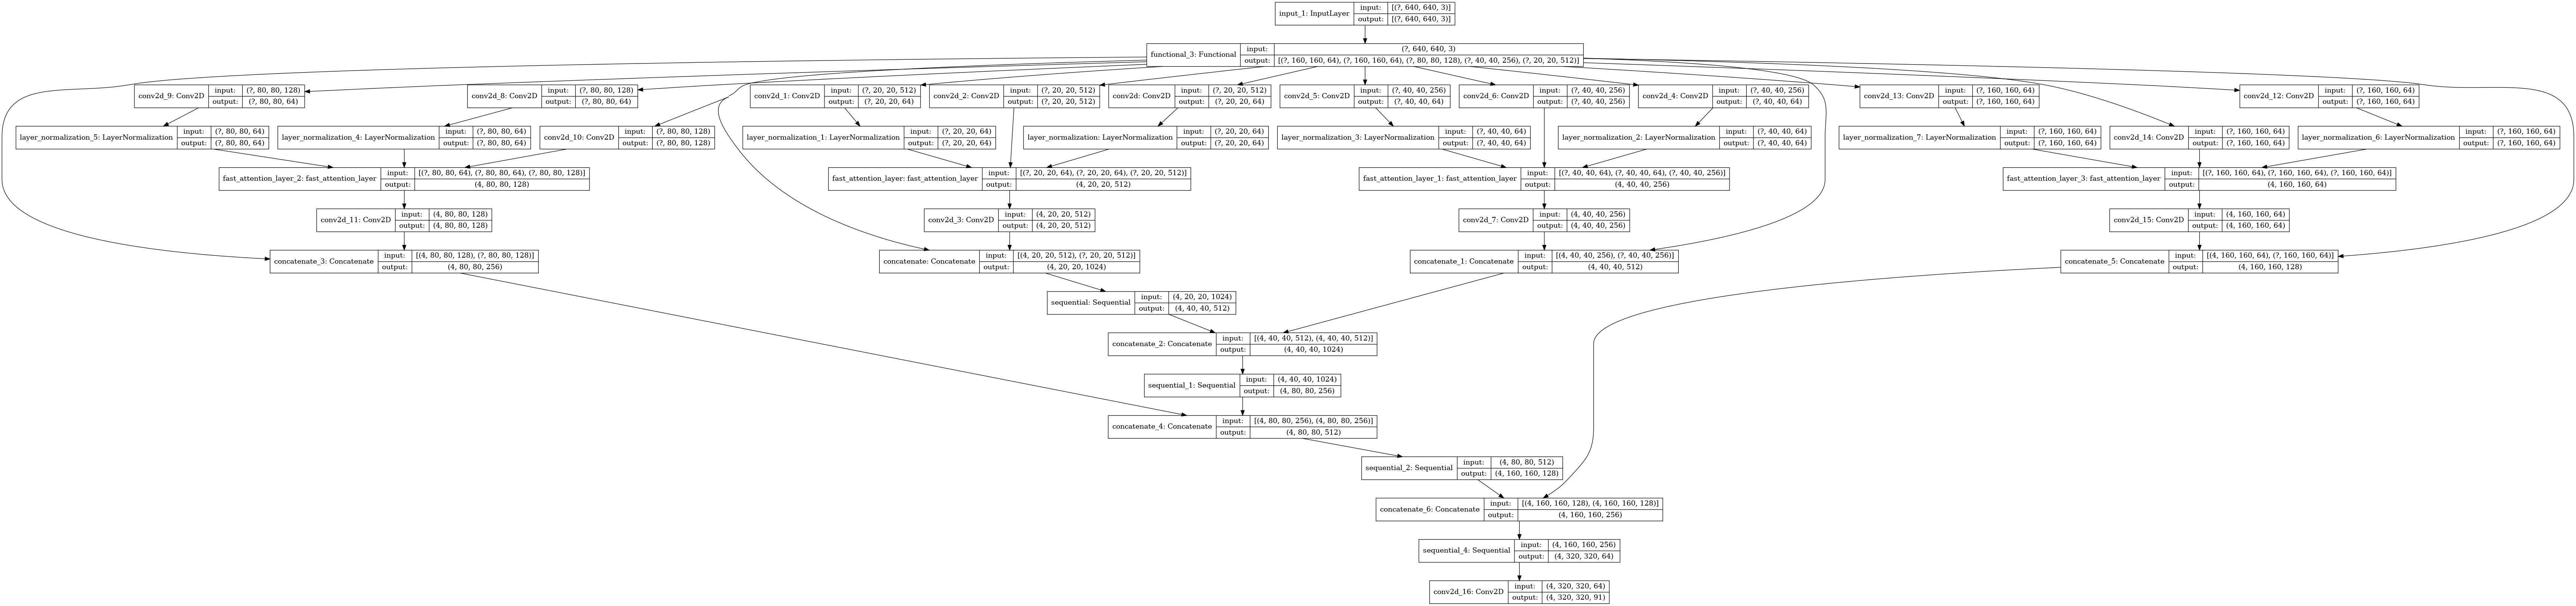

In [3]:
################################################################################
#
# Definir el modelo base (backbone) o codificador
#
################################################################################

ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model=ResNet18((input_shape[0],input_shape[1],3),weights='imagenet',include_top=False)

layers_name=["stage1_unit1_relu1","stage2_unit1_relu1","stage3_unit1_relu1","stage4_unit1_relu1","relu1"]
layers =[base_model.get_layer(name).output for name in layers_name]

# Diferencia 1: En lugar de tomar directamente los outputs del modelo base,
# crea un mismo modelo con la misma entrada de datos y de forma explícita
# declara como outputs las salidas de las capas que queremos coger en lugar de
# cogerlas y ya.
down_stack=tf.keras.Model(inputs=base_model.input,outputs=layers)
down_stack.trainable=False

################################################################################
#
# Definir la capa de atención
#
################################################################################
class fast_attention_layer(tf.keras.layers.Layer):
    """docstring for multiply."""

    def __init__(self,batch_size,input_shapeQK,input_shapeV,**kwargs):
        super(fast_attention_layer, self).__init__(**kwargs)
        self.batch_size=batch_size
        self.input_shapeQK=input_shapeQK
        self.input_shapeV=input_shapeV
        self.trainable=False

    def call(self,input):
        filaQK=self.input_shapeQK[0]*self.input_shapeQK[1]
        filaV=self.input_shapeV[0]*self.input_shapeV[1]

        matrizQ=tf.reshape(input[0],[self.batch_size,filaQK,self.input_shapeQK[2]])
        matrizK=tf.reshape(input[1],[self.batch_size,filaQK,self.input_shapeQK[2]])
        matrizV=tf.reshape(input[2],[self.batch_size,filaV,self.input_shapeV[2]])

        matrizKV=tf.matmul(matrizK,matrizV,transpose_a=True,transpose_b=False)

        attention=tf.matmul(matrizQ,matrizKV,transpose_a=False,transpose_b=False)/(self.input_shapeQK[0]+self.input_shapeQK[1])

        return tf.reshape(attention,[self.batch_size,self.input_shapeQK[0],self.input_shapeQK[1],self.input_shapeV[2]])

    def get_config(self):
        config=super().get_config().copy()
        config.update({
                'batch_size':self.batch_size,
                'input_shapeQK':self.input_shapeQK,
                'input_shapeV':self.input_shapeV,
                'trainable':self.trainable
        })
        return config

def FastAttention(inputs,filters,batch_size,input_shape):
    #inputs=keras.Input(shape=input_shape)
    channels=64

    q=tf.keras.layers.Conv2D(channels,1)(inputs) # Aquí vale 32 según el paper
    q_norm = tf.keras.layers.LayerNormalization()(q)

    k=tf.keras.layers.Conv2D(channels,1)(inputs)
    k_norm = tf.keras.layers.LayerNormalization()(k) # Aquí vale 32 según el paper

    v=tf.keras.layers.Conv2D(filters,1,activation='relu')(inputs)

    #dot_kv=layers.multiply([k_norm,v])
    #dot_qkv=layers.multiply([q_norm,dot_kv])
    dot_qkv=fast_attention_layer(batch_size,(input_shape[1],input_shape[2],channels),(input_shape[1],input_shape[2],filters))([q_norm,k_norm,v])

    conv = tf.keras.layers.Conv2D(filters,1,activation='relu')(dot_qkv)

    fast_attention = tf.keras.layers.Concatenate()([conv,inputs])

    return fast_attention



################################################################################
#
# Definir el decodificador. Como upsample se utiliza el definido en
#        https://www.tensorflow.org/tutorials/generative/pix2pix
# como indica la guía.
#
# Diferencia 2: Como decía el paper, usábamos directamente los bloques de UpSampling2D
# porque así nos ahorrábamos itempo de entrenamiento.
#
################################################################################

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

# Num filers y kernel de la convolución
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
    upsample(64,3)
]

channels = [256,128,64]

def unet_model(output_channels,input_shape):
    inputs = tf.keras.layers.Input(shape=[input_shape[0],input_shape[1],3])
    x = inputs

  # Downsampling through the model
    skips =down_stack(x)
    x=skips[-1]
    x = FastAttention(x,512,batch_size,x.shape)
    skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
    for up, skip,channel in zip(up_stack, skips,channels):
        x = up(x)
        fast_attention=FastAttention(skip,channel,batch_size,skip.shape)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, fast_attention])
    
    x=up_stack[-1](x)

  # This is the last layer of the model
    last=tf.keras.layers.Conv2D(output_channels,3,padding='same')

    x = last(x)
    #x=tf.keras.layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


################################################################################
#
# Creamos y compilamos el modelo
#
################################################################################
model = unet_model(OUTPUT_CHANNELS,input_shape)

################################################################################
#
# Cargamos los datos.  En lugar de usar un generador como en las versiones anteriores,
# cargaremos directamente la carpeta donde estan como en la api esa y como hacen en:
#    https://www.depends-on-the-definition.com/unet-keras-segmenting-images/
#
################################################################################

# Get and resize train images and masks
def get_data(path,batch_size, train=True,input_shape=(128,128)):
    if train:
        ids = next(os.walk(path + "/train"))[2]
    else:
        ids = next(os.walk(path + "/test"))[2]
    #pºrint('Getting and resizing images ... ')
    c=0
    #augmentations=iaa.SomeOf((0,2),[
    #            iaa.Fliplr(0.5),
    #            iaa.Affine(scale=(0.5,1.5)),
    #            iaa.Affine(translate_percent=(-0.2,0.2))
    #            ],random_order=False)
    while(True):
        X = np.zeros((batch_size, input_shape[0], input_shape[1], 3), dtype=np.float32)
        y = np.zeros((batch_size, int(input_shape[0]/2),int(input_shape[1]/2), 1), dtype=np.int32)
        #for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        for n in range(c,c+batch_size):
            id_=ids[n]
            if train:
            # Load images
                img = image.load_img(path + '/train-ALL/' + id_, target_size=input_shape)
                x_img = image.img_to_array(img)
                plt.figure()
                plt.axis('off')
                plt.imshow(img)
                plt.savefig("img"+str(n), bbox_inches='tight',transparent=True, pad_inches=0)
                #x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
            else:
                img = image.load_img(path + '/test-ALL/' + id_, target_size=input_shape)
                x_img = image.img_to_array(img)
                plt.figure()
                plt.axis('off')
                plt.imshow(img)
                plt.savefig("val"+str(n), bbox_inches='tight',transparent=True, pad_inches=0)

            # Load masks
            if train:
                id_=id_[:-3]+'png'
                mask = image.img_to_array(image.load_img(path + '/train-ann-ALL/' + id_,color_mode='grayscale', target_size=(int(input_shape[0]/2),int(input_shape[1]/2))),dtype='int32')
                #mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
                plt.figure()
                plt.axis('off')
                plt.imshow(mask)
                plt.savefig("img-ann"+str(n), bbox_inches='tight',transparent=True, pad_inches=0)
            else:
                id_=id_[:-3]+'png'
                mask = image.img_to_array(image.load_img(path + '/test-ann-ALL/' + id_,color_mode='grayscale', target_size=(int(input_shape[0]/2),int(input_shape[1]/2))),dtype='int32')
                #mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
                plt.figure()
                plt.axis('off')
                plt.imshow(mask)
                plt.savefig("val-ann"+str(n), bbox_inches='tight',transparent=True, pad_inches=0)

            # Save images
            #X[n-c],y[n-c] = augmentations(image=preprocess_input(x_img),segmentation_maps=np.expand_dims(mask,0))#x_img.squeeze() / 255
            X[n-c]=preprocess_input(x_img)
            y[n-c]=np.expand_dims(mask,0)

        c+=batch_size
        if c+batch_size >= len(ids):
            c=0


        yield X,y


keras.utils.plot_model(model, "UnetAttention.png",show_shapes=True)

In [4]:
def showMask(m,lenClasses,input_shape):
    mask=np.zeros((int(input_shape[0]/2),int(input_shape[1]/2)))
    for i in range((int(input_shape[0]/2))):
        for j in range((int(input_shape[1]/2))):
            categoria=0
            for k in range(lenClasses):
                if m[i,j,k] > m[i,j,categoria]:
                    mask[i,j]=k
                    categoria=k
            #print(categoria)
    
    #plt.imshow(mask)
    return mask

In [5]:
def pixel_bbox_cat(mask,cat):
    i,j=np.where(mask==cat)
    if i.size > 0 and j.size >0:
        bbox_x=[np.min(i),np.min(i),np.max(i),np.max(i),np.min(i)]
        bbox_y=[np.min(j),np.max(j),np.max(j),np.min(j),np.min(j)]
    
        return [i,j],[bbox_x,bbox_y]
    else:
        return [i,j],[[],[]]

In [6]:
def mostrar(image,mask,txt):
    for cat in range(OUTPUT_CHANNELS):
        #print(categories[cat])
        if(cat!=1):
            if(cat==0):
                pixel,bbox=pixel_bbox_cat(image,cat)
            else:
                pixel,bbox=pixel_bbox_cat(image,cat-1)
            #print(pixel)
            #print(bbox)
            fils,cols=np.where(mask[:,:,0]==cat)
            if(len(fils)>0):
                plt.figure()
                plt.axis('off')
                plt.title('Pixel Level and Bbox:'+categories[cat])
                plt.imshow(np.zeros((int(input_shape[0]/2),int(input_shape[1]/2)), dtype=np.int32))
                plt.plot(cols,fils,'y,')
                #plt.plot(bbox[1],bbox[0],'r')
                plt.plot(pixel[1],pixel[0],'b,')
                plt.savefig("pred"+txt+str(cat), bbox_inches='tight',transparent=True, pad_inches=0)

### Cargamos las imágenes comparativas

In [7]:
train_gen = get_data(path_train,batch_size,train=True,input_shape=input_shape)
val_gen = get_data(path_train,batch_size,train=False,input_shape=input_shape)

Train




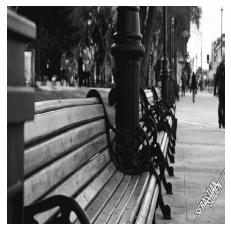

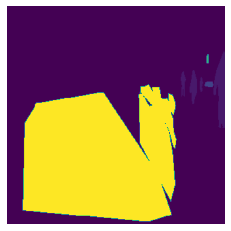

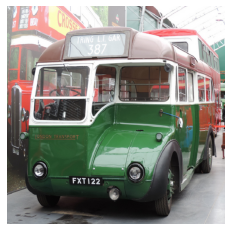

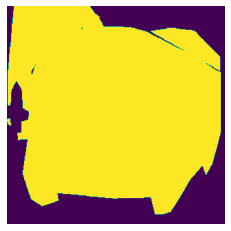

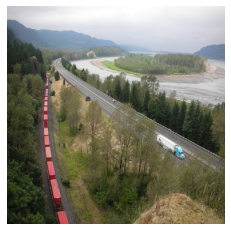

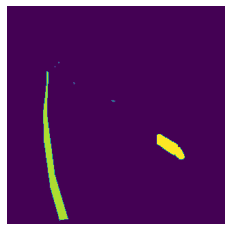

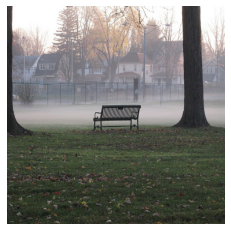

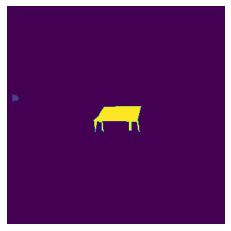

In [8]:
print("Train\n\n")
img_train,mask_train=next(train_gen)

Mask




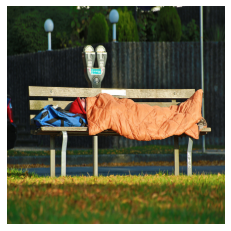

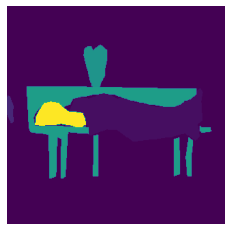

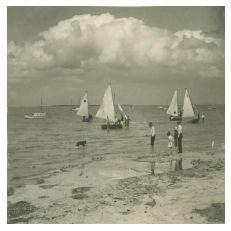

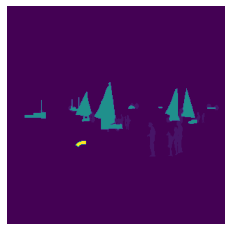

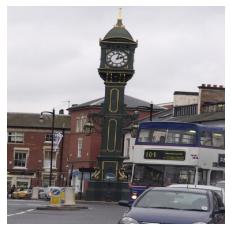

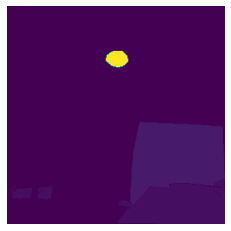

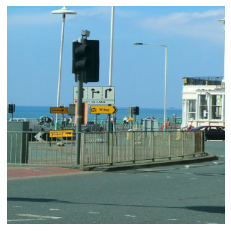

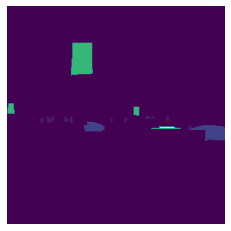

In [9]:
print("Mask\n\n")
img_val,mask_val=next(val_gen)

In [10]:
#for m in mask_train:
#    plt.figure()
#    plt.imshow(m)

## Ejecución 10

optimizer='adam'
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=['accuracy']]
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-con-preprocess.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

**CON** augmentations durante el entrenamiento

### Gráficas

In [11]:
history = json.load(open('./history.json', 'r'))
loss=np.array(list(history['loss'].values())).astype('float')
val_loss=np.array(list(history['val_loss'].values())).astype('float')
acc=np.array(list(history['accuracy'].values())).astype('float')
val_acc=np.array(list(history['val_accuracy'].values())).astype('float')
iou=np.array(list(history['updated_mean_io_u'].values())).astype('float')
val_iou=np.array(list(history['val_updated_mean_io_u'].values())).astype('float')

In [12]:
np.array(list(history))

array(['loss', 'accuracy', 'updated_mean_io_u', 'val_loss',
       'val_accuracy', 'val_updated_mean_io_u', 'lr'], dtype='<U21')

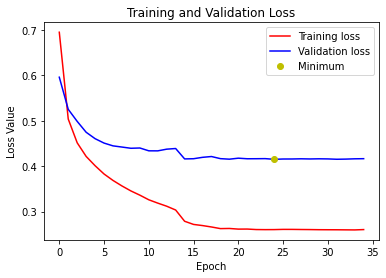

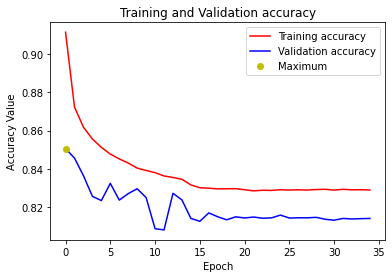

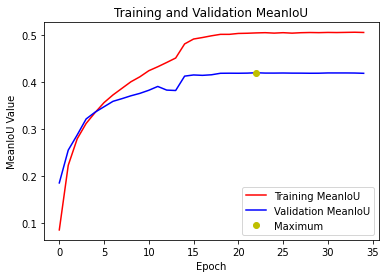

In [13]:
plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.plot(np.argmin(val_loss),np.amin(val_loss),'yo',label="Minimum")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.savefig("loss.jpg", bbox_inches='tight')
#plt.show()

plt.figure()
plt.plot(acc, 'r', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.plot(np.argmax(val_acc),np.amax(val_acc),'yo',label="Maximum")
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.savefig("acc.jpg", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(iou, 'r', label='Training MeanIoU')
plt.plot(val_iou, 'b', label='Validation MeanIoU')
plt.plot(np.argmax(val_iou),np.amax(val_iou),'yo',label="Maximum")
plt.title('Training and Validation MeanIoU')
plt.xlabel('Epoch')
plt.ylabel('MeanIoU Value')
plt.legend()
plt.savefig("iou.jpg", bbox_inches='tight')
plt.show()

### Cargamos el modelo y mostramos resultados del Checkpoint

In [14]:
model.load_weights('./model-con-preprocess.h5')

Predicciones en train

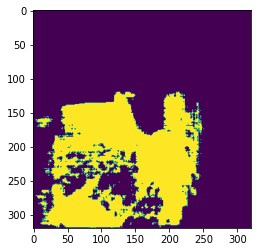

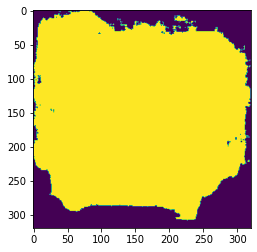

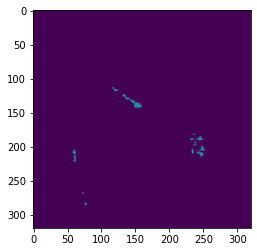

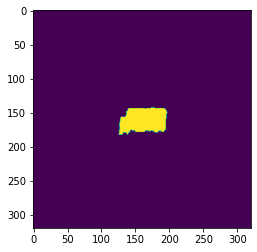

In [15]:
pred=model.predict(img_train)
pred_train = []
for p in pred:
    plt.figure()
    mask=showMask(p,OUTPUT_CHANNELS,input_shape)
    pred_train.append(mask)
    plt.imshow(mask)

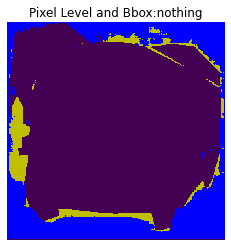

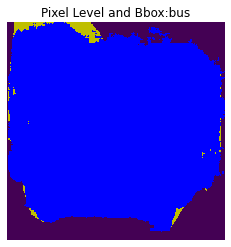

In [16]:
#print(mask_train[1].shape)
mostrar(pred_train[1],mask_train[1],'trainmid')

Predicciones en val

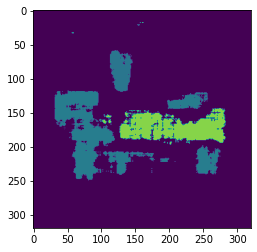

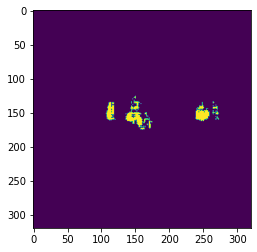

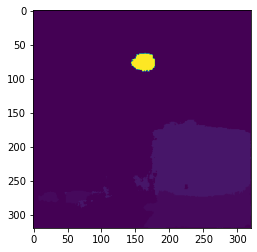

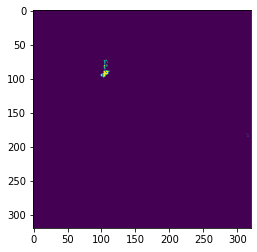

In [17]:
pred=model.predict(img_val)
pred_val = []
for p in pred:
    plt.figure()
    mask=showMask(p,OUTPUT_CHANNELS,input_shape)
    pred_val.append(mask)
    plt.imshow(mask)

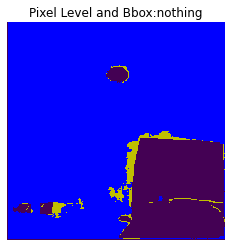

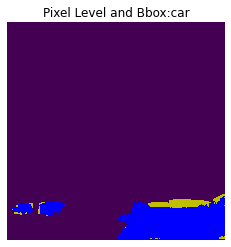

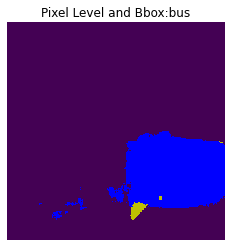

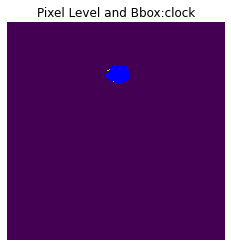

In [18]:
mostrar(pred_val[2],mask_val[2],'valmid')

### Cargamos el modelo y mostramos resultados tras todo el entrenamiento

In [19]:
model.load_weights('./attention_buena.h5')

Predicciones train

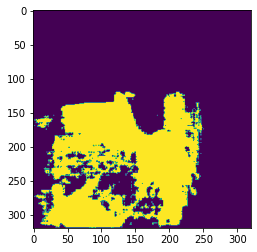

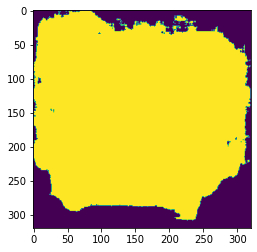

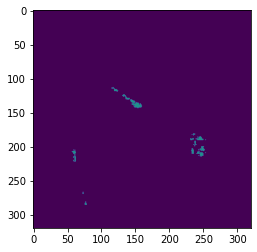

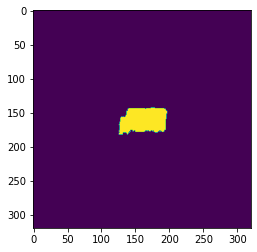

In [20]:
pred=model.predict(img_train)
pred_train = []
for p in pred:
    plt.figure()
    mask=showMask(p,OUTPUT_CHANNELS,input_shape)
    pred_train.append(mask)
    plt.imshow(mask)

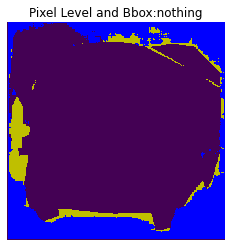

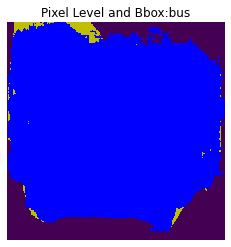

In [21]:
mostrar(pred_train[1],mask_train[1],'trainpost')

Predicciones Val

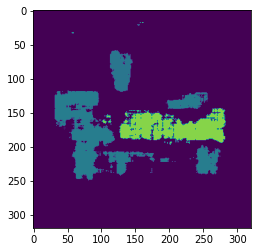

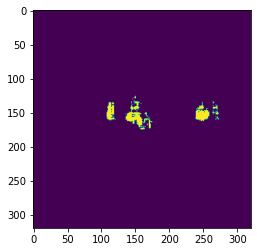

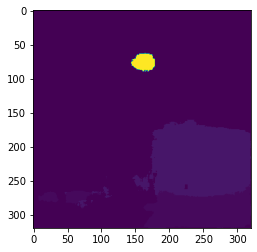

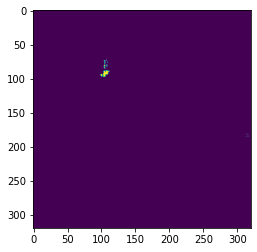

In [22]:
pred=model.predict(img_val)
pred_val = []
for p in pred:
    plt.figure()
    mask=showMask(p,OUTPUT_CHANNELS,input_shape)
    pred_val.append(mask)
    plt.imshow(mask)

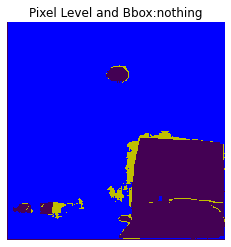

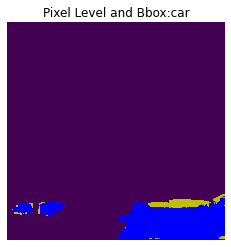

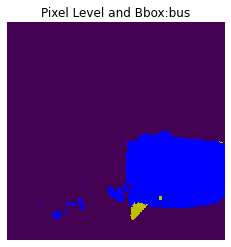

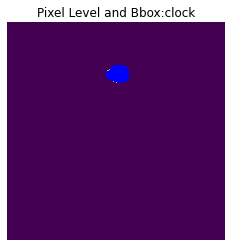

In [23]:
mostrar(pred_val[2],mask_val[2],'valpost')